In [ ]:
!nvidia-smi

Sat Nov  2 12:31:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Set up directories and imports

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.4/112.6 GB disk)


## Testing the non-finetuned model on a sample image

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11s.pt')
image = Image.open('/content/1.jpg')
result = model.predict(image, conf=0.4)[0]


0: 448x640 1 pan, 46.2ms
Speed: 24.5ms preprocess, 46.2ms inference, 1097.6ms postprocess per image at shape (1, 3, 448, 640)


In [ ]:
result.boxes.xyxy

tensor([[ 637.2383,  445.1172, 1011.2139,  684.4163]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.7338], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([1.], device='cuda:0')

## Plot the result using supervision

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Dataset

- For this task I used a dataset available on the Roboflow website

- Created a dataset directory, to download the dataset using the Roboflow API

- to run the cell one needs to have Roboflow Private API token generated at their website

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets


In [ ]:
from google.colab import userdata
from roboflow import Roboflow
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("my-workspace-v1a9m").project("segmentation-fagvi-ohsjf-ixeac-5lxle")
version = project.version(3)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
%cd {HOME}

/content


## Train using YOLO CLI

In [ ]:
!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 plots=True

100% 18.4M/18.4M [00:00<00:00, 141MB/s] 
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/SEGMENTATION-3/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

## Plot the metrics

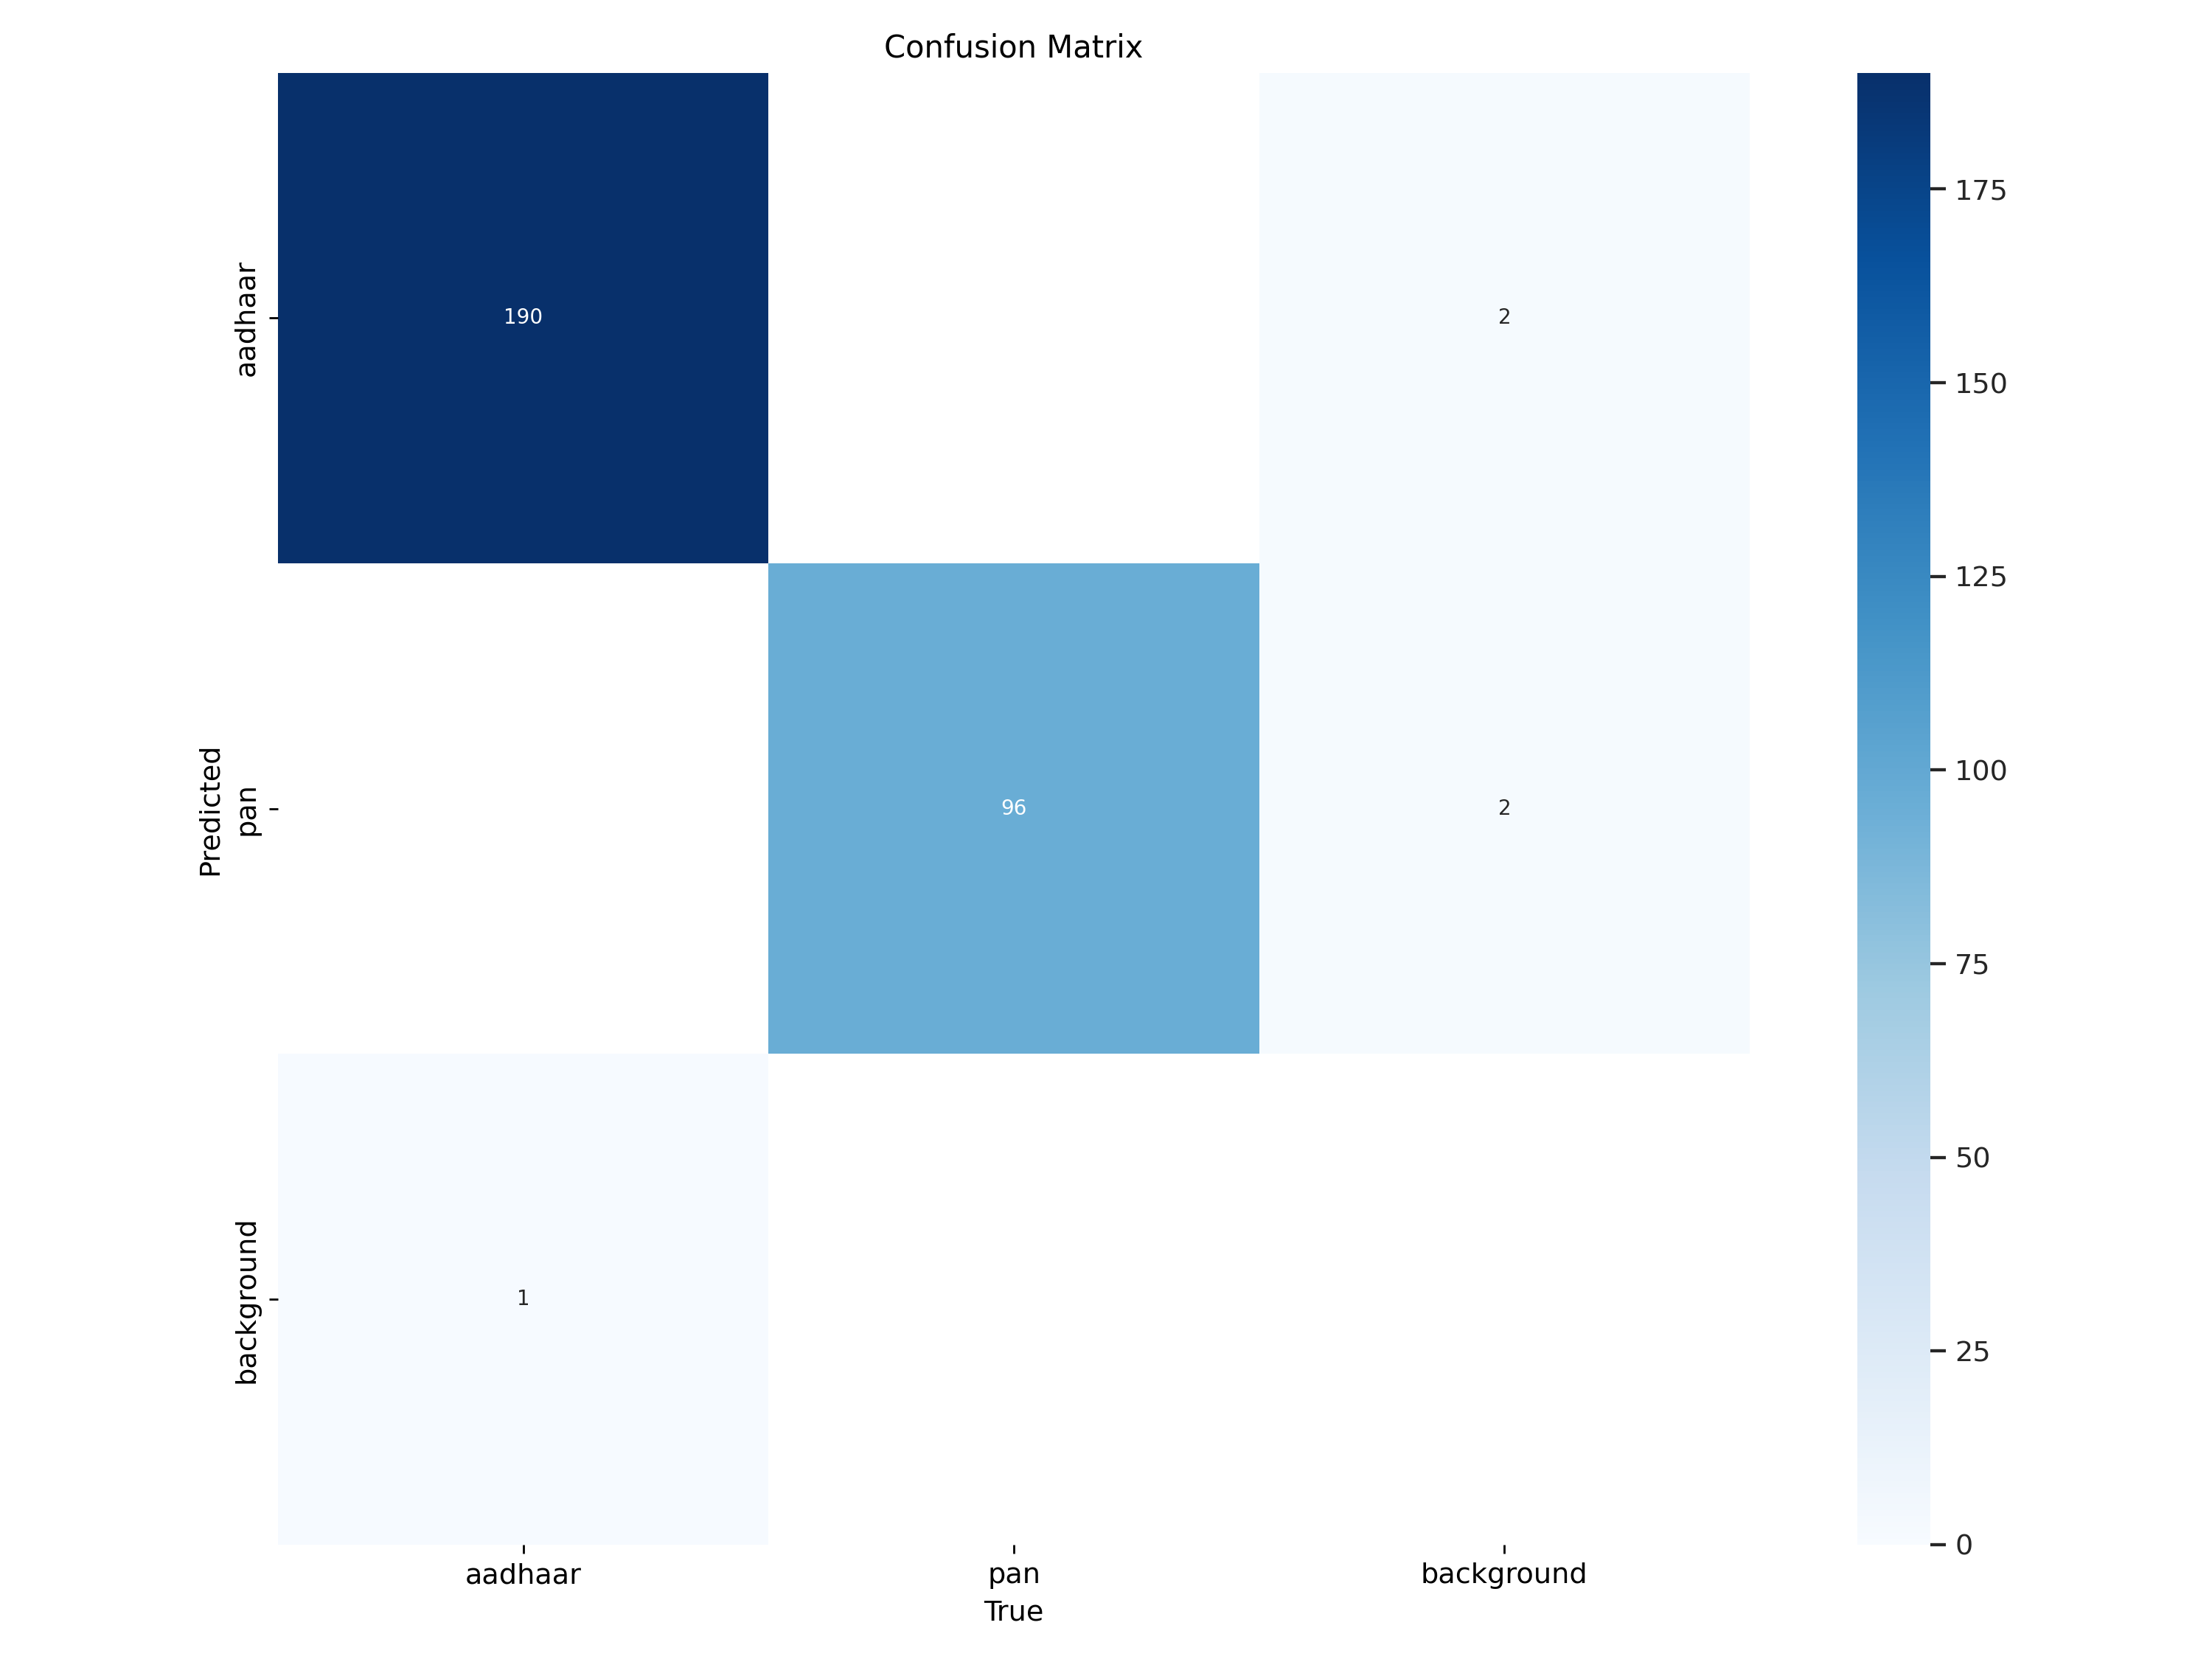

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

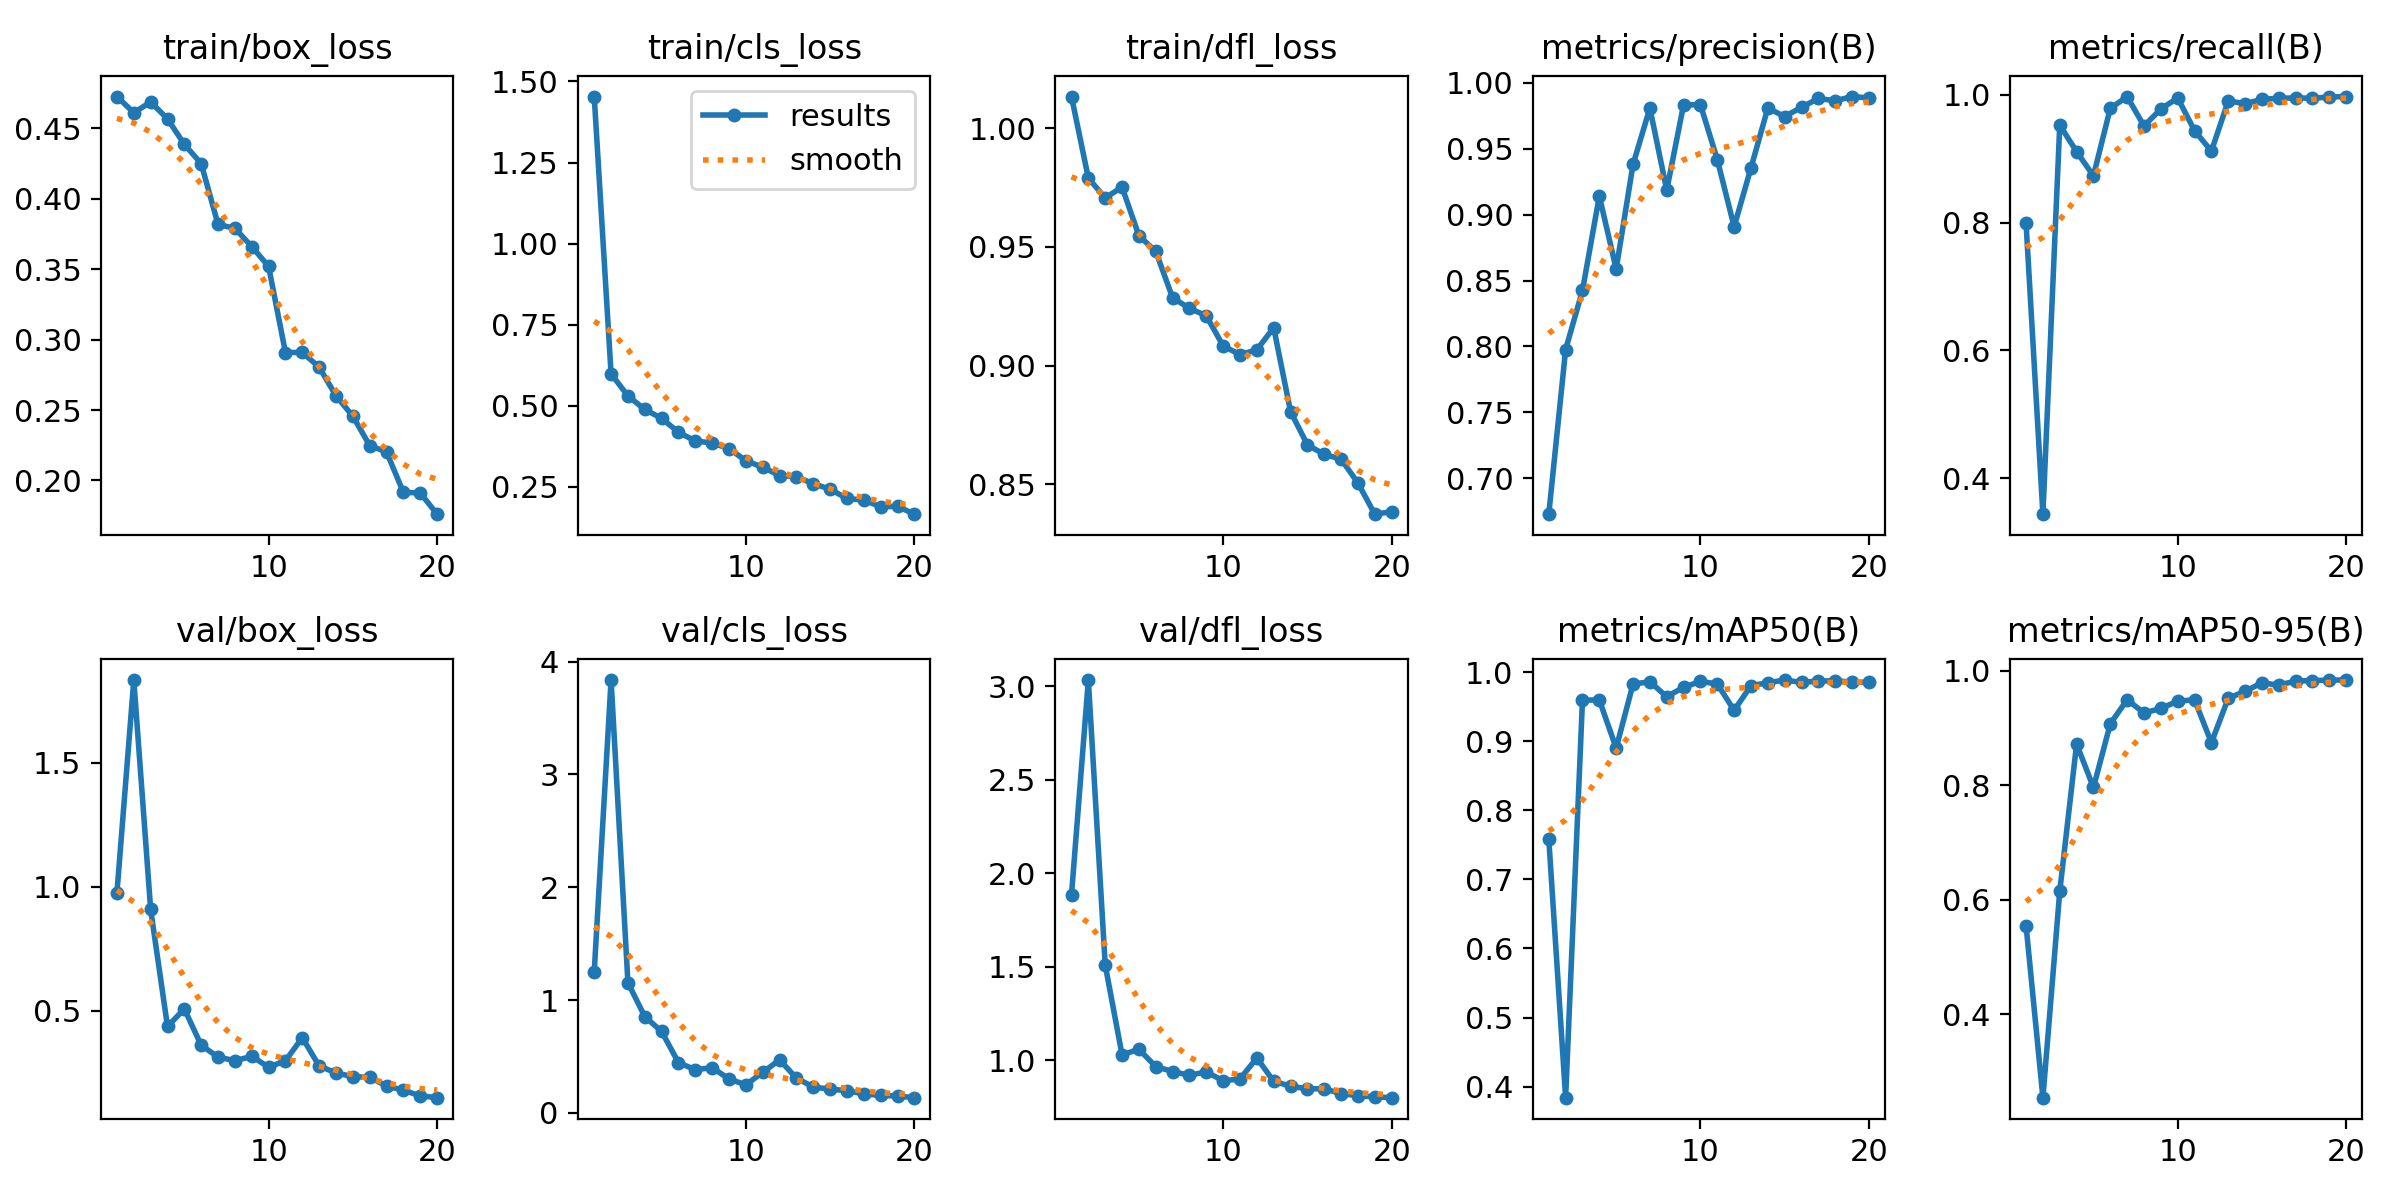

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

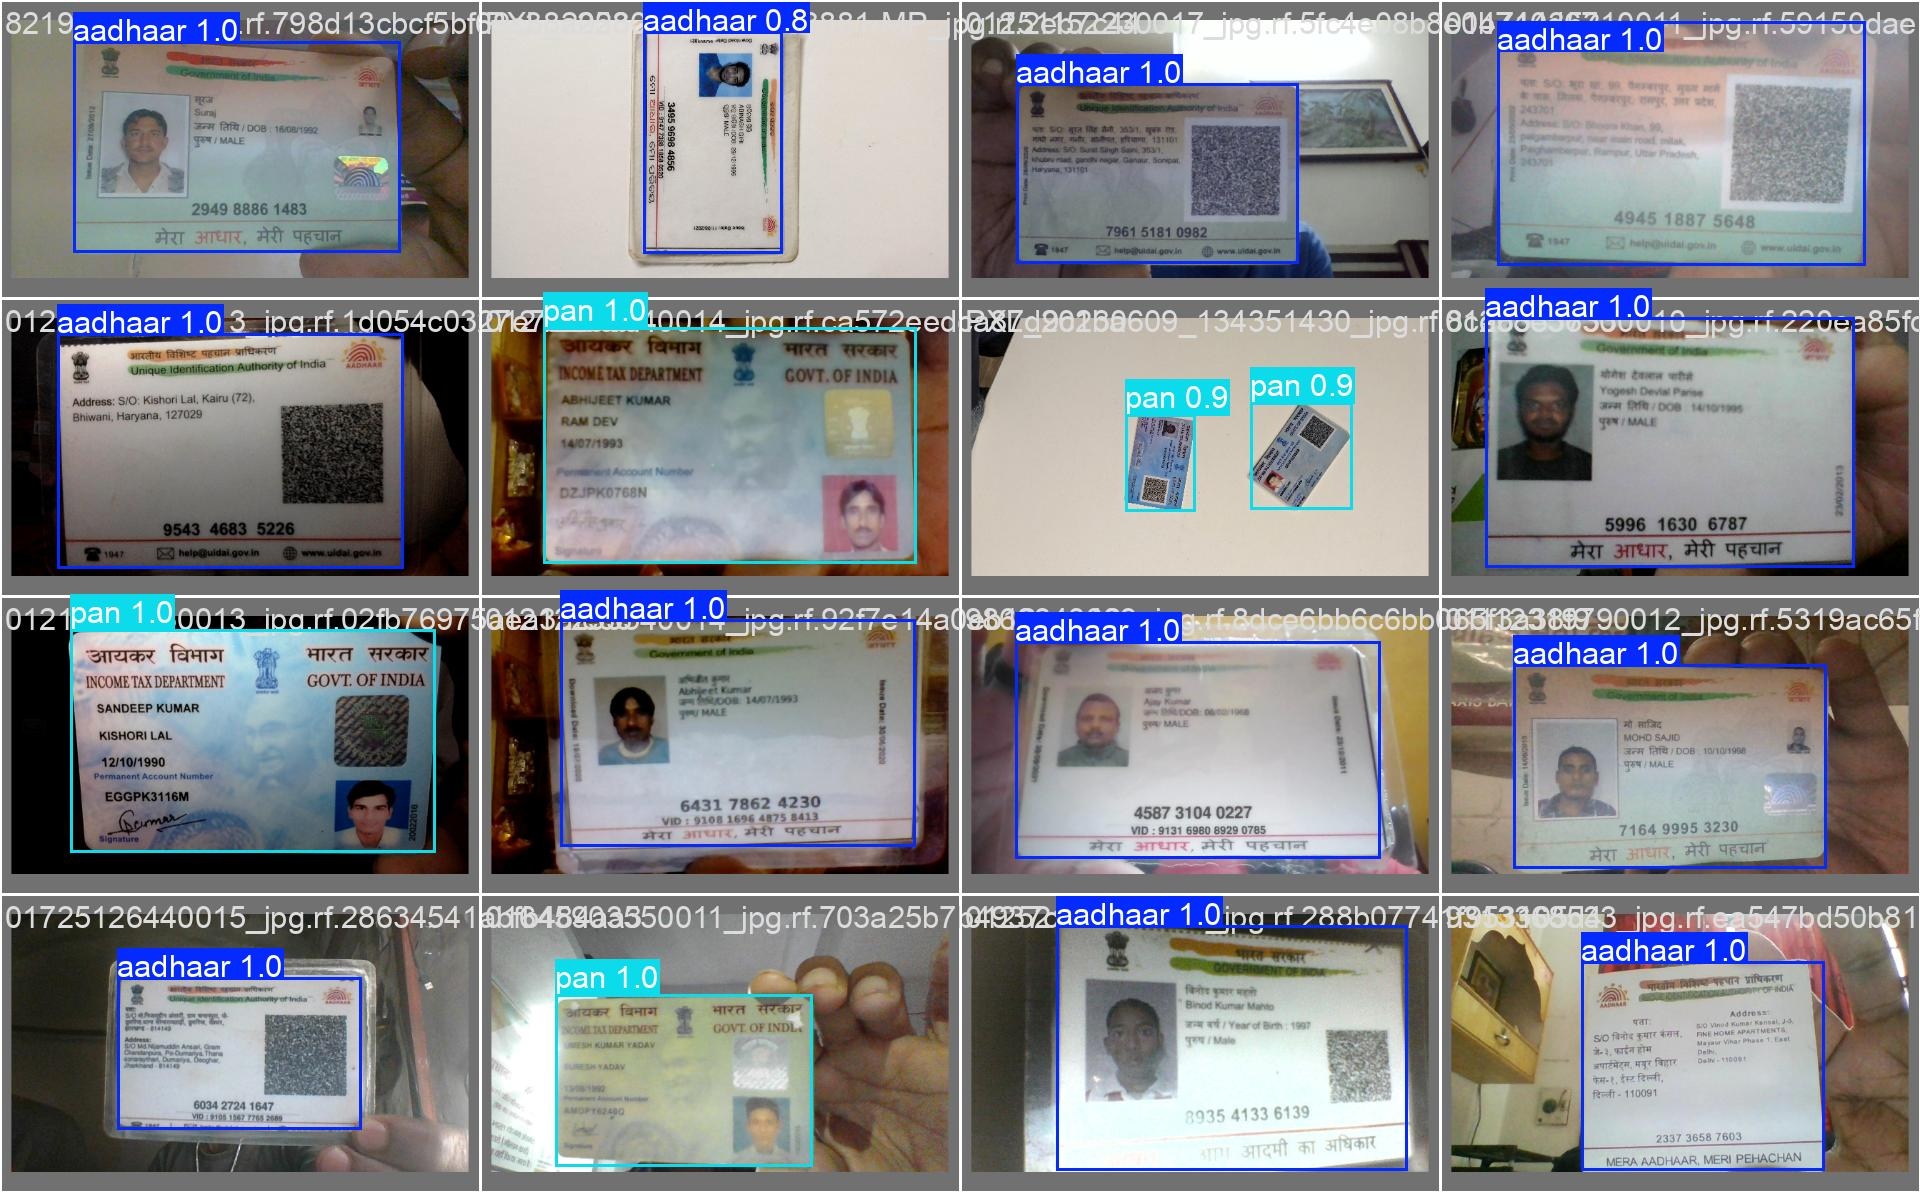

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=900)

## Detection on validation dataset

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/SEGMENTATION-3/valid/labels.cache... 277 images, 1 backgrounds, 0 corrupt: 100% 277/277 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/SEGMENTATION-3/valid/images/01215672330014_jpg.rf.80af71996a01dc46b91e19220b0efe2e.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 18/18 [00:05<00:00,  3.13it/s]
                   all        277        287      0.985      0.995      0.986      0.984
               aadhaar        187        191          1      0.995      0.995      0.992
                   pan         93         96       0.97      0.994      0.976      0.976
Speed: 1.0ms preprocess, 8.7ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics

## Running predictions on test images

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/150 /content/datasets/SEGMENTATION-3/test/images/01111666140013_jpg.rf.a7aee1f54272bf6a12aff1da5f1b92ed.jpg: 416x640 1 pan, 49.6ms
image 2/150 /content/datasets/SEGMENTATION-3/test/images/01125761720016_jpg.rf.b5e7771d1ffbeed2cf5756b76206ce64.jpg: 640x480 1 aadhaar, 76.1ms
image 3/150 /content/datasets/SEGMENTATION-3/test/images/01147347510019_jpg.rf.3af9929505efd8ab09bc1bc88be7404f.jpg: 416x640 1 aadhaar, 16.2ms
image 4/150 /content/datasets/SEGMENTATION-3/test/images/01147347510019_jpg.rf.b5b7801305d27bd1a4d177cac53cf7e3.jpg: 416x640 1 pan, 11.8ms
image 5/150 /content/datasets/SEGMENTATION-3/test/images/01174714750015_jpg.rf.e25a879f09710959ffcc069547b9cbc2.jpg: 416x640 1 aadhaar, 11.9ms
image 6/150 /content/datasets/SEGMENTATION-3/test/images/01213254430016_jpg.rf.e625f68a9f7a90381c49d5bab3669ef5.jpg: 416x640 1

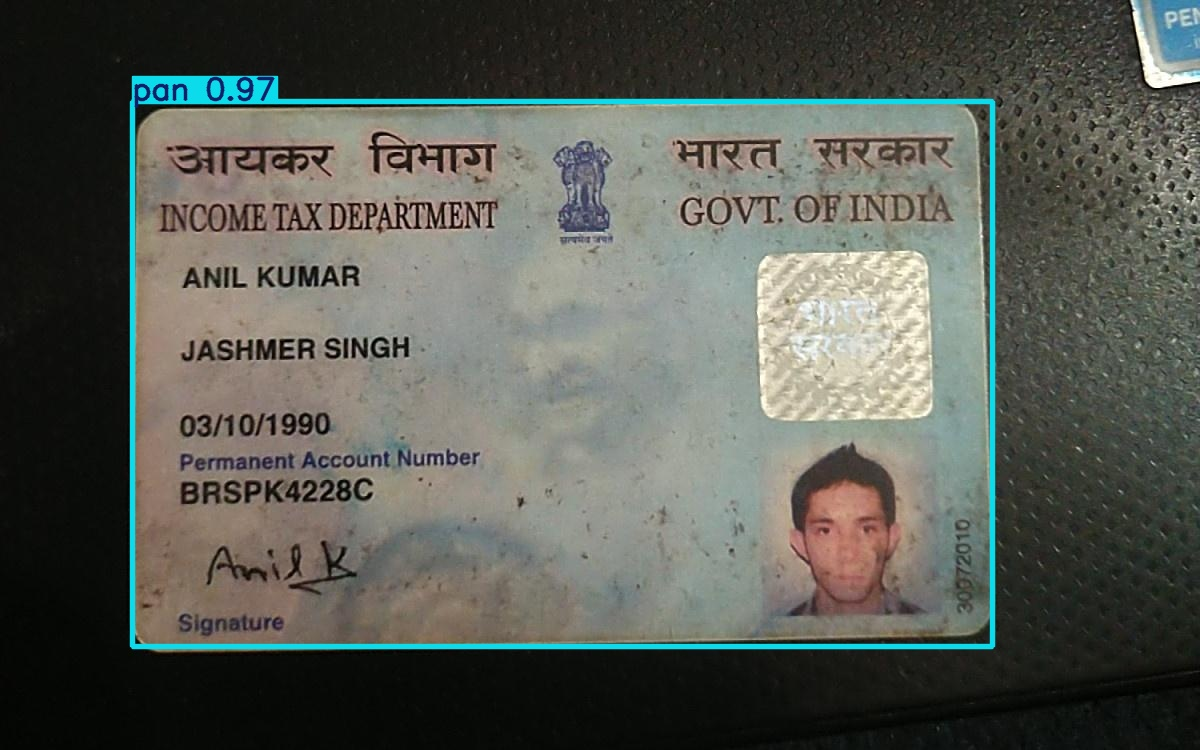

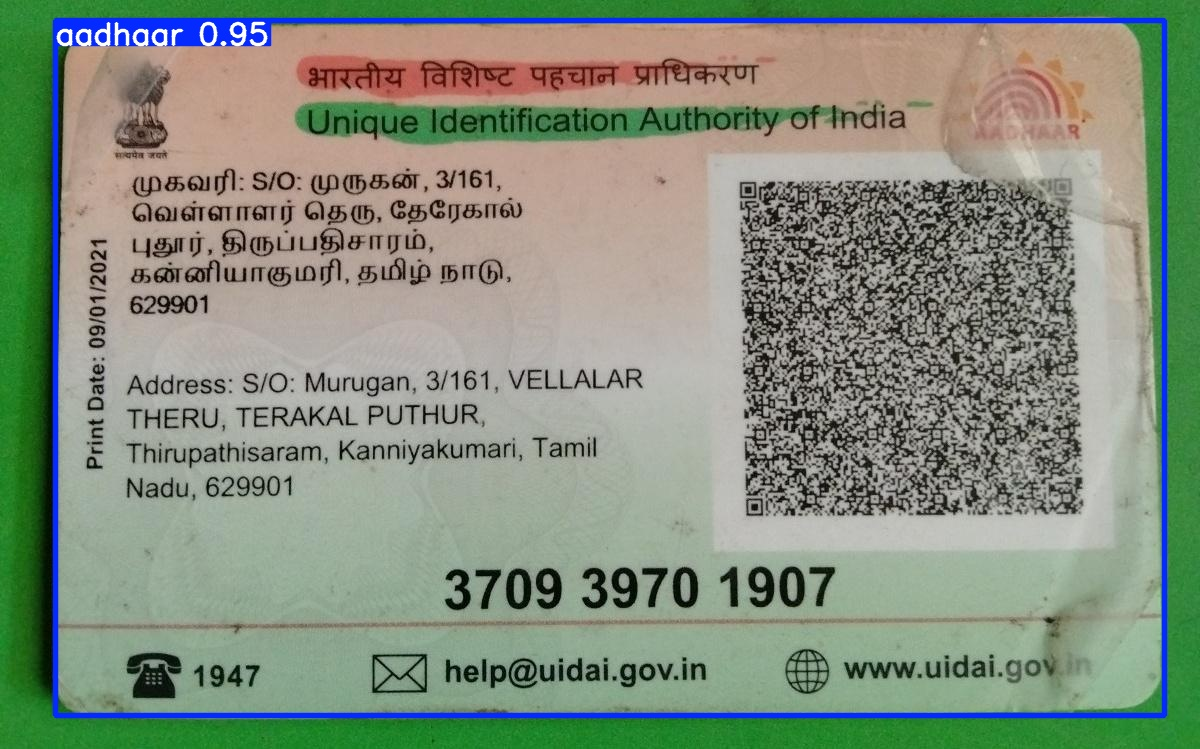

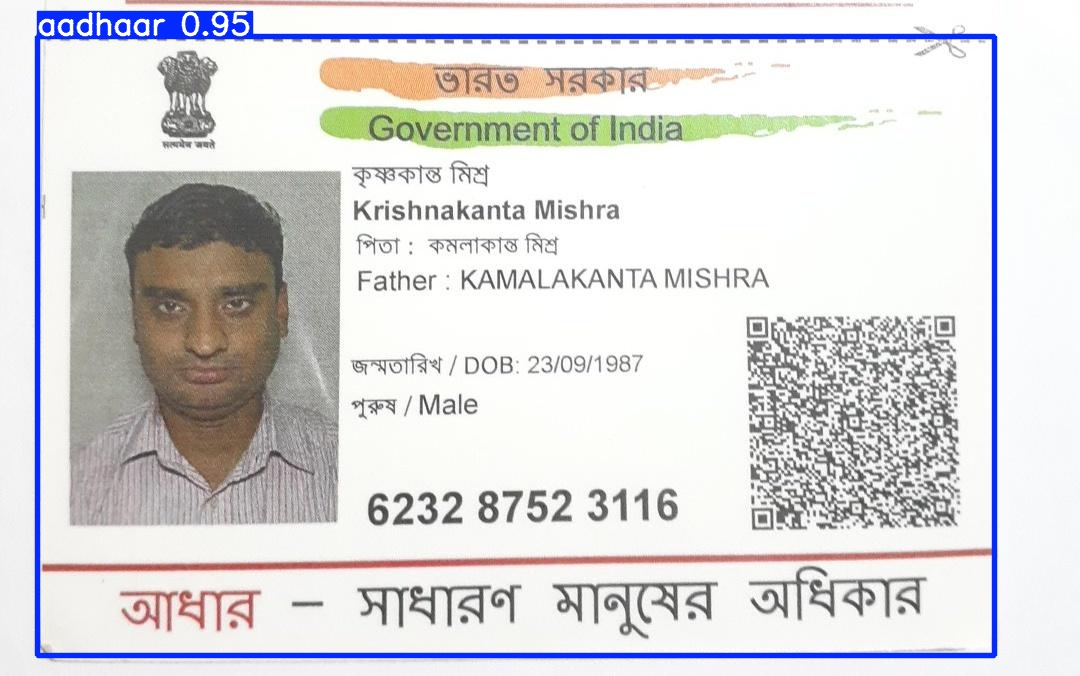

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploying to roboflow workspace

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

View the status of your deployment at: https://app.roboflow.com/my-workspace-v1a9m/segmentation-fagvi-ohsjf-ixeac-5lxle/3
Share your model with the world at: https://universe.roboflow.com/my-workspace-v1a9m/segmentation-fagvi-ohsjf-ixeac-5lxle/model/3
